In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_loader, test_loader = mnist()

In [8]:
class Net(nn.Module):
    def __init__(self, log_softmax=False):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)
        self.log_softmax = log_softmax
        self.optim = optim.SGD(self.parameters(), lr=1.0)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        if self.log_softmax:
            x = F.log_softmax(x, dim=1)
        else:
            x = torch.log(F.softmax(x, dim=1))
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [9]:
def train(epoch, models):
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in models.items()])
        print(line + losses)

In [10]:
def test(models, log=None):
    test_size = len(test_loader.dataset)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)
    
    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in test_loader:
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [11]:
models = {'softmax' : Net(), 'log_softmax' : Net(True)}
test_log = {k: [] for k in models}

epochs = 50
for epoch in range(1, epochs+1):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, test_log)

Train Epoch: 1 [0/60000 (0%)]	Losses softmax: 2.286606 log_softmax: 2.334868
Train Epoch: 1 [10000/60000 (17%)]	Losses softmax: 0.828123 log_softmax: 0.830305
Train Epoch: 1 [20000/60000 (33%)]	Losses softmax: 0.382881 log_softmax: 0.447917
Train Epoch: 1 [30000/60000 (50%)]	Losses softmax: 0.340589 log_softmax: 0.316796
Train Epoch: 1 [40000/60000 (67%)]	Losses softmax: 0.289061 log_softmax: 0.260181
Train Epoch: 1 [50000/60000 (83%)]	Losses softmax: 0.262251 log_softmax: 0.278048
Train Epoch: 1 [60000/60000 (100%)]	Losses softmax: 0.196524 log_softmax: 0.171068
Test set:
softmax: Loss: 0.1767	Accuracy: 9457.0/10000 (95%)
log_softmax: Loss: 0.1606	Accuracy: 9507.0/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Losses softmax: 0.051905 log_softmax: 0.063675
Train Epoch: 2 [10000/60000 (17%)]	Losses softmax: 0.203124 log_softmax: 0.124507
Train Epoch: 2 [20000/60000 (33%)]	Losses softmax: 0.214884 log_softmax: 0.201342
Train Epoch: 2 [30000/60000 (50%)]	Losses softmax: 0.051667 log_softmax:

Train Epoch: 13 [10000/60000 (17%)]	Losses softmax: 0.000657 log_softmax: 0.000134
Train Epoch: 13 [20000/60000 (33%)]	Losses softmax: 0.000230 log_softmax: 0.000407
Train Epoch: 13 [30000/60000 (50%)]	Losses softmax: 0.000661 log_softmax: 0.001729
Train Epoch: 13 [40000/60000 (67%)]	Losses softmax: 0.000115 log_softmax: 0.000112
Train Epoch: 13 [50000/60000 (83%)]	Losses softmax: 0.000391 log_softmax: 0.000280
Train Epoch: 13 [60000/60000 (100%)]	Losses softmax: 0.000882 log_softmax: 0.000542
Test set:
softmax: Loss: 0.0669	Accuracy: 9823.0/10000 (98%)
log_softmax: Loss: 0.0656	Accuracy: 9832.0/10000 (98%)

Train Epoch: 14 [0/60000 (0%)]	Losses softmax: 0.000853 log_softmax: 0.000488
Train Epoch: 14 [10000/60000 (17%)]	Losses softmax: 0.000802 log_softmax: 0.000291
Train Epoch: 14 [20000/60000 (33%)]	Losses softmax: 0.000191 log_softmax: 0.000157
Train Epoch: 14 [30000/60000 (50%)]	Losses softmax: 0.000182 log_softmax: 0.000326
Train Epoch: 14 [40000/60000 (67%)]	Losses softmax: 0.000

Train Epoch: 25 [10000/60000 (17%)]	Losses softmax: 0.000153 log_softmax: 0.000340
Train Epoch: 25 [20000/60000 (33%)]	Losses softmax: 0.000128 log_softmax: 0.000271
Train Epoch: 25 [30000/60000 (50%)]	Losses softmax: 0.000100 log_softmax: 0.000145
Train Epoch: 25 [40000/60000 (67%)]	Losses softmax: 0.000031 log_softmax: 0.000016
Train Epoch: 25 [50000/60000 (83%)]	Losses softmax: 0.000230 log_softmax: 0.000188
Train Epoch: 25 [60000/60000 (100%)]	Losses softmax: 0.001056 log_softmax: 0.000842
Test set:
softmax: Loss: 0.0714	Accuracy: 9829.0/10000 (98%)
log_softmax: Loss: 0.0710	Accuracy: 9836.0/10000 (98%)

Train Epoch: 26 [0/60000 (0%)]	Losses softmax: 0.000049 log_softmax: 0.000077
Train Epoch: 26 [10000/60000 (17%)]	Losses softmax: 0.000282 log_softmax: 0.000187
Train Epoch: 26 [20000/60000 (33%)]	Losses softmax: 0.000615 log_softmax: 0.000217
Train Epoch: 26 [30000/60000 (50%)]	Losses softmax: 0.000332 log_softmax: 0.000193
Train Epoch: 26 [40000/60000 (67%)]	Losses softmax: 0.000

Train Epoch: 37 [10000/60000 (17%)]	Losses softmax: 0.000313 log_softmax: 0.000207
Train Epoch: 37 [20000/60000 (33%)]	Losses softmax: 0.000018 log_softmax: 0.000015
Train Epoch: 37 [30000/60000 (50%)]	Losses softmax: 0.000045 log_softmax: 0.000113
Train Epoch: 37 [40000/60000 (67%)]	Losses softmax: 0.000388 log_softmax: 0.000263
Train Epoch: 37 [50000/60000 (83%)]	Losses softmax: 0.000071 log_softmax: 0.000051
Train Epoch: 37 [60000/60000 (100%)]	Losses softmax: 0.000034 log_softmax: 0.000100
Test set:
softmax: Loss: 0.0745	Accuracy: 9825.0/10000 (98%)
log_softmax: Loss: 0.0742	Accuracy: 9836.0/10000 (98%)

Train Epoch: 38 [0/60000 (0%)]	Losses softmax: 0.000095 log_softmax: 0.000083
Train Epoch: 38 [10000/60000 (17%)]	Losses softmax: 0.000024 log_softmax: 0.000017
Train Epoch: 38 [20000/60000 (33%)]	Losses softmax: 0.000135 log_softmax: 0.000129
Train Epoch: 38 [30000/60000 (50%)]	Losses softmax: 0.000091 log_softmax: 0.000041
Train Epoch: 38 [40000/60000 (67%)]	Losses softmax: 0.000

Train Epoch: 49 [10000/60000 (17%)]	Losses softmax: 0.000410 log_softmax: 0.000325
Train Epoch: 49 [20000/60000 (33%)]	Losses softmax: 0.000085 log_softmax: 0.000085
Train Epoch: 49 [30000/60000 (50%)]	Losses softmax: 0.000139 log_softmax: 0.000155
Train Epoch: 49 [40000/60000 (67%)]	Losses softmax: 0.000068 log_softmax: 0.000078
Train Epoch: 49 [50000/60000 (83%)]	Losses softmax: 0.000024 log_softmax: 0.000036
Train Epoch: 49 [60000/60000 (100%)]	Losses softmax: 0.000178 log_softmax: 0.000098
Test set:
softmax: Loss: 0.0766	Accuracy: 9822.0/10000 (98%)
log_softmax: Loss: 0.0762	Accuracy: 9835.0/10000 (98%)

Train Epoch: 50 [0/60000 (0%)]	Losses softmax: 0.000122 log_softmax: 0.000044
Train Epoch: 50 [10000/60000 (17%)]	Losses softmax: 0.000131 log_softmax: 0.000105
Train Epoch: 50 [20000/60000 (33%)]	Losses softmax: 0.000108 log_softmax: 0.000128
Train Epoch: 50 [30000/60000 (50%)]	Losses softmax: 0.000016 log_softmax: 0.000009
Train Epoch: 50 [40000/60000 (67%)]	Losses softmax: 0.000

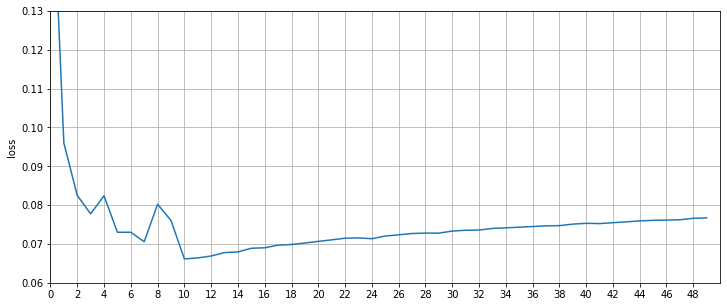

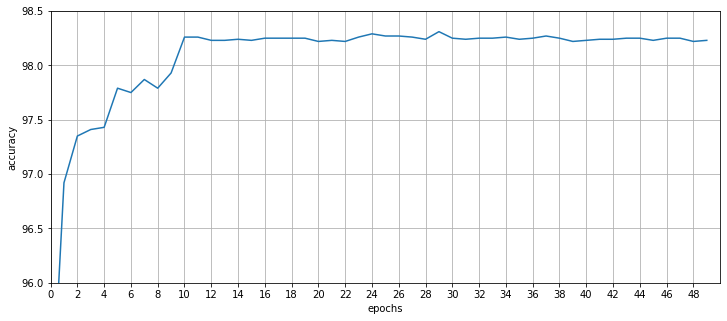

In [14]:
test_loss_softmax = [i[0] for i in test_log['softmax']]
test_acc_softmax = [i[1] for i in test_log['softmax']]
test_loss_log_softmax = [i[0] for i in test_log['log_softmax']]
test_acc_log_softmax = [i[1] for i in test_log['log_softmax']]

plt.figure(figsize=(12, 5))
plt.plot(range(0, epochs), test_loss_softmax)
plt.xticks(range(0, epochs, 2))
plt.xlim((0, 50))
plt.ylim((0.06, 0.13))
plt.ylabel('loss')
plt.grid()

plt.figure(figsize=(12, 5))
plt.plot(range(0, epochs), test_acc_softmax)
plt.xlabel('epochs')
plt.xticks(range(0, epochs, 2))
plt.xlim((0, 50))
plt.ylim((96, 98.5))
plt.ylabel('accuracy')
plt.grid()

In [15]:
test_loss_softmax[49]

0.07672819804179253